In [2]:
import pickle
import numpy as np
import os
import torch
import json
import shlex
import pickle
import time
import subprocess
import numpy as np
import torch.utils.data as data
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import datasets.data_utils as d_utils
import pandas as pd

from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.metrics import accuracy_score
from utils.util import AverageMeter, shapenetpart_metrics
from models.backbones import ResNet
from models.heads import ClassifierResNet, MultiPartSegHeadResNet, SceneSegHeadResNet
from models.losses import LabelSmoothingCrossEntropyLoss, MultiShapeCrossEntropy, MaskedCrossEntropy
from utils.config import config, update_config
from utils.lr_scheduler import get_scheduler
from torchvision import transforms
from sklearn.metrics import roc_curve, auc
from IPython.display import clear_output
import pickle

def config_seting(cfg = 'cfgs/brain/brain.yaml'):
    update_config(cfg)
    return config


# Usefull functional for visualisation

In [3]:

class BrainDataSeg():
    def __init__(self, data_type = 'train', num_points = 2048, 
                 transforms=None,
                 data_post = '',
                 datafolder = 'BrainData'):
        self.num_points = num_points
        self.transforms = transforms
        if data_type == 'test':
            filename = f'data/{datafolder}/test_data{data_post}.pkl'
        if data_type == 'train':
            filename = f'data/{datafolder}/trainval_data{data_post}.pkl'
        with open(filename, 'rb') as f:
            self.points, self.points_labels, self.labels = pickle.load(f)
        print(f"{filename} loaded successfully")

    def __getitem__(self, idx):
        current_points = self.points[idx]
        current_points_labels = self.points_labels[idx]
        cur_num_points = current_points.shape[0]
        if cur_num_points >= self.num_points:
            choice = np.random.choice(cur_num_points, self.num_points)
            current_points = current_points[choice, :]
            current_points_labels = current_points_labels[choice]
            mask = torch.ones(self.num_points).type(torch.int32)
        else:
            padding_num = self.num_points - cur_num_points
            shuffle_choice = np.random.permutation(np.arange(cur_num_points))
            padding_choice = np.random.choice(cur_num_points, padding_num)
            choice = np.hstack([shuffle_choice, padding_choice])
            current_points = current_points[choice, :]
            current_points_labels = current_points_labels[choice]
            mask = torch.cat([torch.ones(cur_num_points), torch.zeros(padding_num)]).type(torch.int32)
        if self.transforms is not None:
            current_points = self.transforms(current_points)
        label = torch.from_numpy(self.labels[idx]).type(torch.int64)
        current_points_labels = torch.from_numpy(current_points_labels).type(torch.int64)

        return current_points, mask, current_points_labels, label

    def __len__(self):
        return len(self.points)
def get_loader(num_points,batch_size = 16,data_post = '', datafolder = 'BrainData'):
    trans = transforms.Compose([d_utils.PointcloudToTensor()])
    train_dataset = BrainDataSeg(num_points=num_points,
                                 data_type = 'train',
                                 transforms = trans, 
                                 data_post = data_post,
                                 datafolder = datafolder
                                )
    test_dataset = BrainDataSeg(num_points=num_points,
                                data_type = 'test',
                                transforms = trans, 
                                data_post = data_post,
                               datafolder = datafolder)
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               pin_memory=True,
                                               drop_last=True)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              pin_memory=True,
                                              drop_last=False)

    return train_loader, test_loader
class MultiPartSegmentationModel(nn.Module):
    def __init__(self, config, backbone, head, num_classes, num_parts,
                 input_features_dim, radius, sampleDl, nsamples, npoints,
                 width=144, depth=2, bottleneck_ratio=2):
        super(MultiPartSegmentationModel, self).__init__()
        if backbone == 'resnet':
            self.backbone = ResNet(config, input_features_dim, radius, sampleDl, nsamples, npoints,
                                   width=width, depth=depth, bottleneck_ratio=bottleneck_ratio)
        else:
            raise NotImplementedError(f"Backbone {backbone} not implemented in Multi-Part Segmentation Model")

        if head == 'resnet_part_seg':
            self.segmentation_head = MultiPartSegHeadResNet(num_classes, width, radius, nsamples, num_parts)
        else:
            raise NotImplementedError(f"Head {backbone} not implemented in Multi-Part Segmentation Model")

    def forward(self, xyz, mask, features):
        end_points = self.backbone(xyz, mask, features)
        return self.segmentation_head(end_points)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
def build_multi_part_segmentation(config, weights = None):
    model = MultiPartSegmentationModel(config, config.backbone, config.head, config.num_classes, config.num_parts,
                                       config.input_features_dim,
                                       config.radius, config.sampleDl, config.nsamples, config.npoints,
                                       config.width, config.depth, config.bottleneck_ratio)
    criterion = MultiShapeCrossEntropy(config.num_classes, weights)
    return model, criterion
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

def train(epoch, train_loader, model, criterion, optimizer, scheduler, config):
    """
    One epoch training
    """
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    loss_meter = AverageMeter()
    end = time.time()
    pred_soft_flats = []
    points_labels_flats = []
    for idx, (points, mask, points_labels, shape_labels) in enumerate(train_loader):
        data_time.update(time.time() - end)
        bsz = points.size(0)
        # forward
        features = points
        features = features.transpose(1, 2).contiguous()

        points = points[:,:,:3].cuda(non_blocking=True)
        mask = mask.cuda(non_blocking=True)
        features = features.cuda(non_blocking=True)
        points_labels = points_labels.cuda(non_blocking=True)
        shape_labels = shape_labels.cuda(non_blocking=True)
        pred = model(points, mask, features)
        loss = criterion(pred, points_labels, shape_labels)
        
        m = torch.nn.Softmax(dim=1)
        pred_soft_flats += list(np.array(m(pred[0])[:,1,:].reshape(-1).detach().cpu()))
        points_labels_flats += list(np.array(points_labels.reshape(-1).detach().cpu()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # update meters
        loss_meter.update(loss.item(), bsz)
        batch_time.update(time.time() - end)
        end = time.time()

    print('roc train',roc_auc_score(points_labels_flats,pred_soft_flats))
    opt = Find_Optimal_Cutoff(points_labels_flats, pred_soft_flats)
    print('optimal cut',opt)

    return loss_meter.avg, opt

def validate(epoch, test_loader, model, criterion, config, num_votes=10, is_conf = False):
    """
    One epoch validating
    """
    batch_time = AverageMeter()
    losses = AverageMeter()

    model.eval()
    with torch.no_grad():
        all_logits = []
        all_points_labels = []
        all_shape_labels = []
        all_masks = []
        end = time.time()
        TS = d_utils.BatchPointcloudScaleAndJitter(scale_low=config.scale_low,
                                                   scale_high=config.scale_high,
                                                   std=config.noise_std,
                                                   clip=config.noise_clip)
        pred_soft_flats = []
        points_labels_flats = []
        for idx, (points_orig, mask, points_labels, shape_labels) in enumerate(test_loader):
            vote_logits = None
            vote_points_labels = None
            vote_shape_labels = None
            vote_masks = None
            for v in range(num_votes):
                batch_logits = []
                batch_points_labels = []
                batch_shape_labels = []
                batch_masks = []
                # augment for voting
                if v > 0:
                    points = TS(points_orig)
                else:
                    points = points_orig
                # forward
                features = points
                features = features.transpose(1, 2).contiguous()
                points = points[:,:,:3].cuda(non_blocking=True)
                mask = mask.cuda(non_blocking=True)
                features = features.cuda(non_blocking=True)
                points_labels = points_labels.cuda(non_blocking=True)
                shape_labels = shape_labels.cuda(non_blocking=True)

                pred = model(points, mask, features)
                loss = criterion(pred, points_labels, shape_labels)
                losses.update(loss.item(), points.size(0))
                
                m = torch.nn.Softmax(dim=1)
                pred_soft_flats += list(np.array(m(pred[0])[:,1,:].reshape(-1).detach().cpu()))
                points_labels_flats += list(np.array(points_labels.reshape(-1).detach().cpu()))
                

                # collect
                bsz = points.shape[0]
                for ib in range(bsz):
                    sl = shape_labels[ib]
                    logits = pred[sl][ib]
                    pl = points_labels[ib]
                    pmk = mask[ib]
                    batch_logits.append(logits.cpu().numpy())
                    batch_points_labels.append(pl.cpu().numpy())
                    batch_shape_labels.append(sl.cpu().numpy())
                    batch_masks.append(pmk.cpu().numpy().astype(np.bool))

                # measure elapsed time
                batch_time.update(time.time() - end)
                end = time.time()

                if vote_logits is None:
                    vote_logits = batch_logits
                    vote_points_labels = batch_points_labels
                    vote_shape_labels = batch_shape_labels
                    vote_masks = batch_masks
                else:
                    for i in range(len(vote_logits)):
                        vote_logits[i] = vote_logits[i] + (batch_logits[i] - vote_logits[i]) / (v + 1)

            all_logits += vote_logits
            all_points_labels += vote_points_labels
            all_shape_labels += vote_shape_labels
            all_masks += vote_masks
            if idx % config.print_freq == 0:
                print(
                    f'V{num_votes} Test: [{idx}/{len(test_loader)}]\t'
                    f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    f'Loss {losses.val:.4f} ({losses.avg:.4f})')
                

        print('roc test',roc_auc_score(points_labels_flats,pred_soft_flats))
            
        if is_conf:
            acc, shape_ious, msIoU, mIoU, confs = shapenetpart_metrics(config.num_classes,
                                                            config.num_parts,
                                                            all_shape_labels,
                                                            all_logits,
                                                            all_points_labels,
                                                            all_masks, is_conf = is_conf)
        else:
            acc, shape_ious, msIoU, mIoU = shapenetpart_metrics(config.num_classes,
                                                            config.num_parts,
                                                            all_shape_labels,
                                                            all_logits,
                                                            all_points_labels,
                                                            all_masks, is_conf = is_conf)
            
    if is_conf:
        return losses.avg,acc, msIoU, mIoU, confs
    else:
        return losses.avg,acc, msIoU, mIoU

# Hyperparameters

In [4]:
# Brain Data FCD
WEIGHTS = [1,167]
CFG = 'cfgs/brain/brain4exp.yaml'
IS_CONF = True
DATAFOLDER = 'BrainData'

# Visualisation

In [5]:
config = config_seting(CFG)

/home/guest/CloserLook3D/pytorch/utils/config.py:108: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))


In [6]:
def d(x, thr):
    if x > thr:
        return 1
    return 0

In [37]:
from tqdm import tqdm
model, _ = build_multi_part_segmentation(config, WEIGHTS)

res = []
dice = []
count_good = 0
cms = []
stds = []
ious = []
std_iou = []
for e in range(8):
    cm = np.zeros((2,2))
    dice_ = []
    iou = []
    for k in tqdm(range(20)):
        DATA_POSTFIX = f'_4exp_{e}'
        train_loader, test_loader = get_loader(num_points = config.num_points, 
                                           data_post = DATA_POSTFIX, 
                                           datafolder = DATAFOLDER )
        try:
            model.load_state_dict(torch.load(f'4_exp_{e}_model.pkl'))
        except Exception:
            print('Model was to bad and didn;t converge!')
            pass
        model.cuda()
        model.eval()

        points,mask, true,_ = test_loader.dataset[0]
        features = points.unsqueeze(0).transpose(1, 2).contiguous().cuda()
        points = points.unsqueeze(0)[:,:,:3].cuda()
        mask = mask.unsqueeze(0).cuda()
        true = true.detach().cpu().numpy()
        opt = 0.5

        pred = [d(x,opt) for x in model(points,mask,features)[0].squeeze(0)[1:].squeeze(0).detach().cpu().numpy()]
        #accuracy_score(true,pred)
        cm = cm + confusion_matrix(true,pred)
        dice_.append(2*np.logical_and(true, pred).sum()/ (true.sum() + sum(pred)))
        iou.append(np.logical_and(true, pred).sum()/ np.logical_or(true, pred).sum())
    print(cm)
    cms.append(cm)
    if (cm[0][1]/cm[0].sum() < 0.1) and (cm[1][0]/cm[1].sum() < 0.2):
        count_good +=1
    dice_ = np.array(dice_)
    dice.append(dice_.mean())
    ious.append(np.array(iou).mean())
    stds.append(dice_.std())
    std_iou.append(np.array(iou).std())
    print('dice: ', dice_.mean())
    print('dice std: ', dice_.std())
    print('iou: ', np.array(iou).mean())
    print('iou std: ', np.array(iou).std())
    res.append([points, true, pred])

  0%|          | 0/20 [00:00<?, ?it/s]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:33,  1.74s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:31,  1.73s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 15%|█▌        | 3/20 [00:05<00:29,  1.72s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:27,  1.72s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:25,  1.73s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 30%|███       | 6/20 [00:10<00:24,  1.75s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 35%|███▌      | 7/20 [00:12<00:22,  1.74s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:20,  1.74s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 45%|████▌     | 9/20 [00:15<00:19,  1.73s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 50%|█████     | 10/20 [00:17<00:17,  1.74s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:15,  1.72s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 60%|██████    | 12/20 [00:20<00:13,  1.70s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 65%|██████▌   | 13/20 [00:22<00:11,  1.71s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 70%|███████   | 14/20 [00:24<00:10,  1.72s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 75%|███████▌  | 15/20 [00:25<00:08,  1.72s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 80%|████████  | 16/20 [00:27<00:06,  1.72s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 85%|████████▌ | 17/20 [00:29<00:05,  1.71s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 90%|█████████ | 18/20 [00:30<00:03,  1.69s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


 95%|█████████▌| 19/20 [00:32<00:01,  1.69s/it]

data/BrainData/trainval_data_4exp_0.pkl loaded successfully
data/BrainData/test_data_4exp_0.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[3.95166e+05 1.18800e+04]
 [2.38000e+03 1.74000e+02]]
dice:  0.018307320863915334
dice std:  0.04673179628218874
iou:  0.009848792942617599
iou std:  0.025899889101159354
data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:35,  1.85s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:32,  1.80s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 15%|█▌        | 3/20 [00:05<00:30,  1.77s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:27,  1.74s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:26,  1.74s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 30%|███       | 6/20 [00:10<00:24,  1.72s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.69s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:20,  1.69s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 45%|████▌     | 9/20 [00:15<00:18,  1.69s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 50%|█████     | 10/20 [00:17<00:17,  1.71s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:15,  1.72s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 60%|██████    | 12/20 [00:20<00:13,  1.74s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 65%|██████▌   | 13/20 [00:22<00:12,  1.73s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 70%|███████   | 14/20 [00:23<00:10,  1.72s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 75%|███████▌  | 15/20 [00:25<00:08,  1.70s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 80%|████████  | 16/20 [00:27<00:06,  1.70s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 85%|████████▌ | 17/20 [00:29<00:05,  1.70s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 90%|█████████ | 18/20 [00:30<00:03,  1.72s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


 95%|█████████▌| 19/20 [00:32<00:01,  1.72s/it]

data/BrainData/trainval_data_4exp_1.pkl loaded successfully
data/BrainData/test_data_4exp_1.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.03592e+05 3.72800e+03]
 [2.09500e+03 1.85000e+02]]
dice:  0.021893814997263273
dice std:  0.0699491542520725
iou:  0.012497839239412273
iou std:  0.040456089843062086
data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:31,  1.68s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:30,  1.69s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 15%|█▌        | 3/20 [00:05<00:28,  1.70s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:26,  1.68s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:25,  1.67s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 30%|███       | 6/20 [00:10<00:23,  1.71s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:22,  1.73s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:20,  1.71s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 45%|████▌     | 9/20 [00:15<00:19,  1.73s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 50%|█████     | 10/20 [00:17<00:17,  1.72s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:15,  1.70s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 60%|██████    | 12/20 [00:20<00:13,  1.69s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 65%|██████▌   | 13/20 [00:22<00:11,  1.68s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 70%|███████   | 14/20 [00:23<00:10,  1.68s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 75%|███████▌  | 15/20 [00:25<00:08,  1.68s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 80%|████████  | 16/20 [00:27<00:06,  1.69s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 85%|████████▌ | 17/20 [00:28<00:05,  1.70s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 90%|█████████ | 18/20 [00:30<00:03,  1.71s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


 95%|█████████▌| 19/20 [00:32<00:01,  1.71s/it]

data/BrainData/trainval_data_4exp_2.pkl loaded successfully
data/BrainData/test_data_4exp_2.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[397147.   9627.]
 [  2340.    486.]]
dice:  0.05517227806225407
dice std:  0.08661261426679714
iou:  0.030563120355314794
iou std:  0.04932144085466351
data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:31,  1.65s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:30,  1.67s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 15%|█▌        | 3/20 [00:05<00:28,  1.68s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:26,  1.68s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:25,  1.70s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 30%|███       | 6/20 [00:10<00:23,  1.69s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.68s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:20,  1.67s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 45%|████▌     | 9/20 [00:15<00:18,  1.68s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.69s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:15,  1.69s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 60%|██████    | 12/20 [00:20<00:13,  1.68s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:11,  1.70s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 70%|███████   | 14/20 [00:23<00:10,  1.70s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 75%|███████▌  | 15/20 [00:25<00:08,  1.68s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.66s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 85%|████████▌ | 17/20 [00:28<00:04,  1.66s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 90%|█████████ | 18/20 [00:30<00:03,  1.69s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


 95%|█████████▌| 19/20 [00:32<00:01,  1.69s/it]

data/BrainData/trainval_data_4exp_3.pkl loaded successfully
data/BrainData/test_data_4exp_3.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.00964e+05 8.49400e+03]
 [1.33000e+02 9.00000e+00]]
dice:  0.0012100204073437232
dice std:  0.0036353937764063474
iou:  0.0006087027213787777
iou std:  0.0018288233588850537
data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


  5%|▌         | 1/20 [00:01<00:29,  1.58s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 10%|█         | 2/20 [00:03<00:28,  1.56s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 15%|█▌        | 3/20 [00:04<00:26,  1.57s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 20%|██        | 4/20 [00:06<00:25,  1.58s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 25%|██▌       | 5/20 [00:07<00:23,  1.58s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 30%|███       | 6/20 [00:09<00:22,  1.58s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 35%|███▌      | 7/20 [00:11<00:20,  1.59s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 40%|████      | 8/20 [00:12<00:19,  1.61s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 45%|████▌     | 9/20 [00:14<00:17,  1.61s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 50%|█████     | 10/20 [00:15<00:16,  1.62s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 55%|█████▌    | 11/20 [00:17<00:14,  1.60s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 60%|██████    | 12/20 [00:19<00:12,  1.59s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 65%|██████▌   | 13/20 [00:20<00:11,  1.59s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 70%|███████   | 14/20 [00:22<00:09,  1.58s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 75%|███████▌  | 15/20 [00:23<00:08,  1.60s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 80%|████████  | 16/20 [00:25<00:06,  1.61s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 85%|████████▌ | 17/20 [00:27<00:04,  1.63s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 90%|█████████ | 18/20 [00:28<00:03,  1.65s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


 95%|█████████▌| 19/20 [00:30<00:01,  1.64s/it]

data/BrainData/trainval_data_4exp_4.pkl loaded successfully
data/BrainData/test_data_4exp_4.pkl loaded successfully
Model was to bad and didn;t converge!


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.05133e+05 4.37900e+03]
 [8.80000e+01 0.00000e+00]]
dice:  0.0
dice std:  0.0
iou:  0.0
iou std:  0.0
data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:32,  1.70s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:30,  1.70s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 15%|█▌        | 3/20 [00:05<00:28,  1.70s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:27,  1.69s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:25,  1.68s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 30%|███       | 6/20 [00:10<00:23,  1.70s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:22,  1.71s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:20,  1.71s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 45%|████▌     | 9/20 [00:15<00:18,  1.72s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 50%|█████     | 10/20 [00:17<00:17,  1.71s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:15,  1.76s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 60%|██████    | 12/20 [00:20<00:13,  1.73s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 65%|██████▌   | 13/20 [00:22<00:12,  1.72s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 70%|███████   | 14/20 [00:23<00:10,  1.72s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 75%|███████▌  | 15/20 [00:25<00:08,  1.69s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 80%|████████  | 16/20 [00:27<00:06,  1.72s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 85%|████████▌ | 17/20 [00:29<00:05,  1.72s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 90%|█████████ | 18/20 [00:30<00:03,  1.72s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


 95%|█████████▌| 19/20 [00:32<00:01,  1.70s/it]

data/BrainData/trainval_data_4exp_5.pkl loaded successfully
data/BrainData/test_data_4exp_5.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[3.93237e+05 1.41330e+04]
 [3.75000e+02 1.85500e+03]]
dice:  0.2183078860632861
dice std:  0.08757794141863881
iou:  0.1253423227224187
iou std:  0.05730605706413896
data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


  5%|▌         | 1/20 [00:01<00:31,  1.65s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 10%|█         | 2/20 [00:03<00:30,  1.67s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 15%|█▌        | 3/20 [00:05<00:28,  1.68s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 20%|██        | 4/20 [00:06<00:26,  1.68s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 25%|██▌       | 5/20 [00:08<00:25,  1.67s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 30%|███       | 6/20 [00:10<00:23,  1.68s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 35%|███▌      | 7/20 [00:11<00:21,  1.67s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 40%|████      | 8/20 [00:13<00:19,  1.66s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 45%|████▌     | 9/20 [00:15<00:18,  1.66s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 50%|█████     | 10/20 [00:16<00:16,  1.67s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 55%|█████▌    | 11/20 [00:18<00:15,  1.68s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 60%|██████    | 12/20 [00:20<00:13,  1.67s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 65%|██████▌   | 13/20 [00:21<00:11,  1.70s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 70%|███████   | 14/20 [00:23<00:10,  1.69s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 75%|███████▌  | 15/20 [00:25<00:08,  1.69s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 80%|████████  | 16/20 [00:26<00:06,  1.67s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 85%|████████▌ | 17/20 [00:28<00:04,  1.67s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 90%|█████████ | 18/20 [00:30<00:03,  1.66s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


 95%|█████████▌| 19/20 [00:31<00:01,  1.66s/it]

data/BrainData/trainval_data_4exp_6.pkl loaded successfully
data/BrainData/test_data_4exp_6.pkl loaded successfully


  0%|          | 0/20 [00:00<?, ?it/s]

[[4.07423e+05 1.04600e+03]
 [5.90000e+01 1.07200e+03]]
dice:  0.7017513330784388
dice std:  0.19284159835852063
iou:  0.5754699837492805
iou std:  0.2371554166729977
data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


  5%|▌         | 1/20 [00:01<00:31,  1.65s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 10%|█         | 2/20 [00:03<00:29,  1.65s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 15%|█▌        | 3/20 [00:04<00:28,  1.65s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 20%|██        | 4/20 [00:06<00:26,  1.63s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 25%|██▌       | 5/20 [00:08<00:24,  1.64s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 30%|███       | 6/20 [00:09<00:22,  1.63s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 35%|███▌      | 7/20 [00:11<00:21,  1.63s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 40%|████      | 8/20 [00:13<00:19,  1.63s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 45%|████▌     | 9/20 [00:14<00:17,  1.62s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 50%|█████     | 10/20 [00:16<00:16,  1.61s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 55%|█████▌    | 11/20 [00:17<00:14,  1.61s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 60%|██████    | 12/20 [00:19<00:12,  1.62s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 65%|██████▌   | 13/20 [00:21<00:11,  1.62s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 70%|███████   | 14/20 [00:22<00:09,  1.61s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 75%|███████▌  | 15/20 [00:24<00:07,  1.60s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 80%|████████  | 16/20 [00:25<00:06,  1.60s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 85%|████████▌ | 17/20 [00:27<00:04,  1.62s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 90%|█████████ | 18/20 [00:29<00:03,  1.62s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


 95%|█████████▌| 19/20 [00:30<00:01,  1.63s/it]

data/BrainData/trainval_data_4exp_7.pkl loaded successfully
data/BrainData/test_data_4exp_7.pkl loaded successfully
Model was to bad and didn;t converge!


100%|██████████| 20/20 [00:32<00:00,  1.62s/it]

[[4.06429e+05 2.09600e+03]
 [1.03000e+02 9.72000e+02]]
dice:  0.5230442777911367
dice std:  0.16333283008336982
iou:  0.3711684716066881
iou std:  0.15507579105739902


In [39]:
print('mean dice score: ', np.array(dice).mean())

mean dice score:  0.19246086640795476


In [40]:
print('dice std: ', np.array(stds).mean())

dice std:  0.08133516605474925


In [41]:
print('mean iou score: ', np.array(ious).mean())

mean iou score:  0.14068740416713882


In [42]:
print('iou std: ', np.array(std_iou).mean())

iou std:  0.0708804384940382


In [43]:
print('good patients: ', count_good)

good patients:  3


In [44]:
count_good = 0
for cm in tqdm(cms):
    if (cm[0][1]/cm[0].sum() < 0.05) and (cm[1][0]/cm[1].sum() < 0.1):
        count_good +=1
print(count_good)

100%|██████████| 8/8 [00:00<00:00, 24618.07it/s]

2


In [50]:
! nvidia-smi

Mon Mar 22 16:08:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:8E:00.0 Off |                    0 |
| N/A   24C    P0    31W / 250W |  11077MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:91:00.0 Off |                    0 |
| N/A   38C    P0   127W / 250W |   6205MiB / 16280MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
        

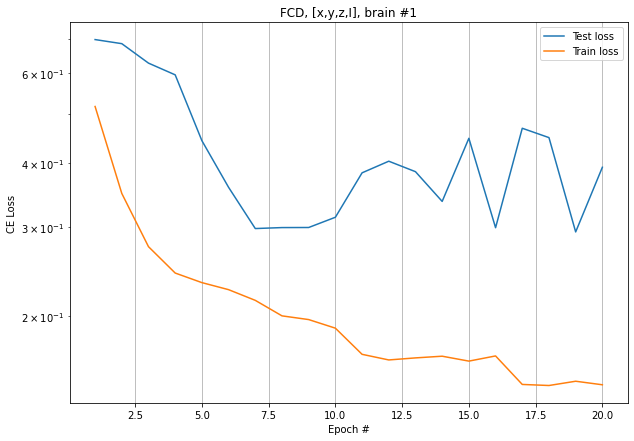

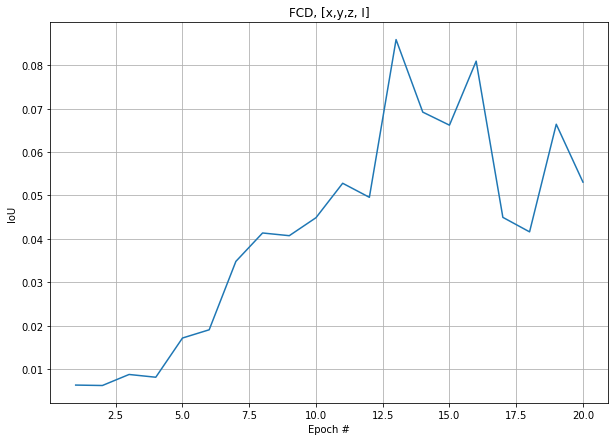

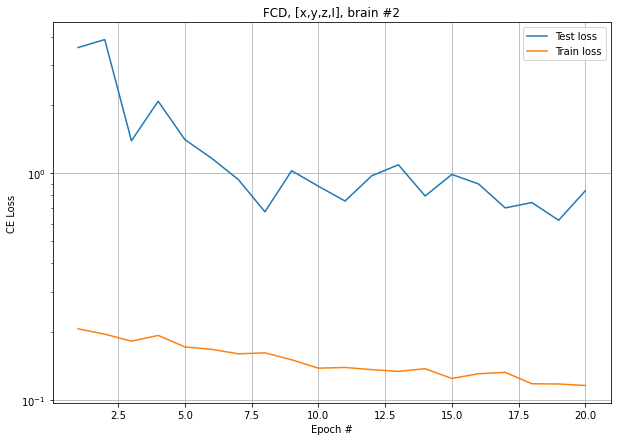

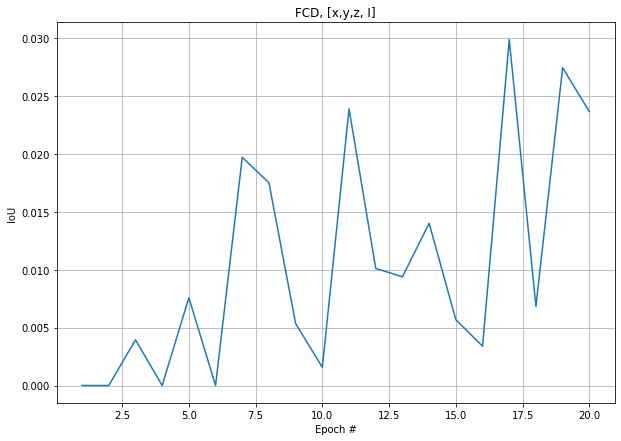

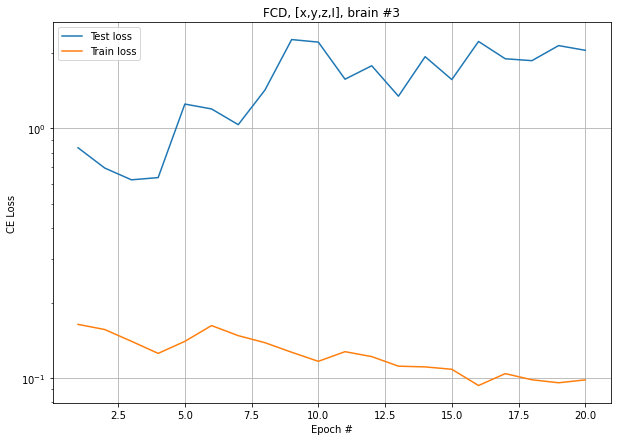

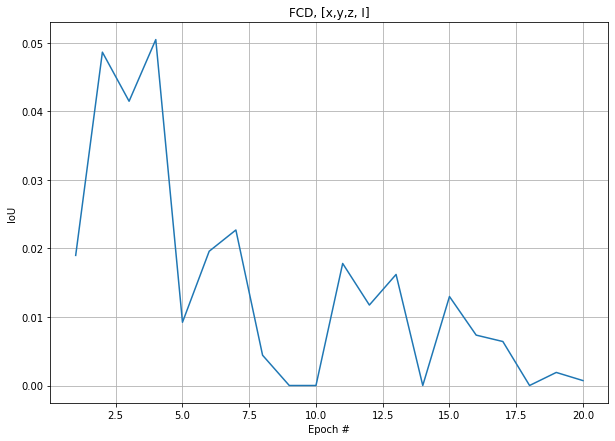

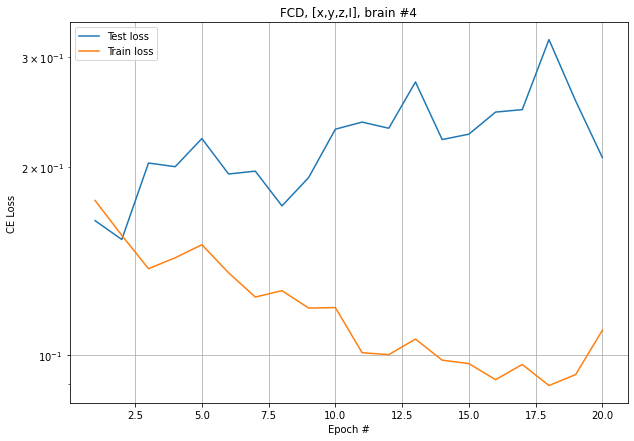

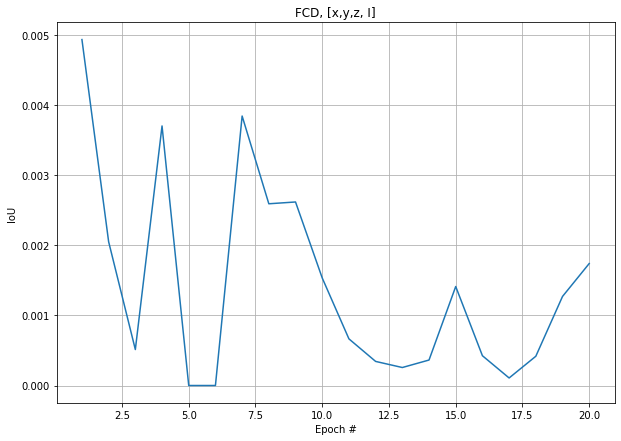

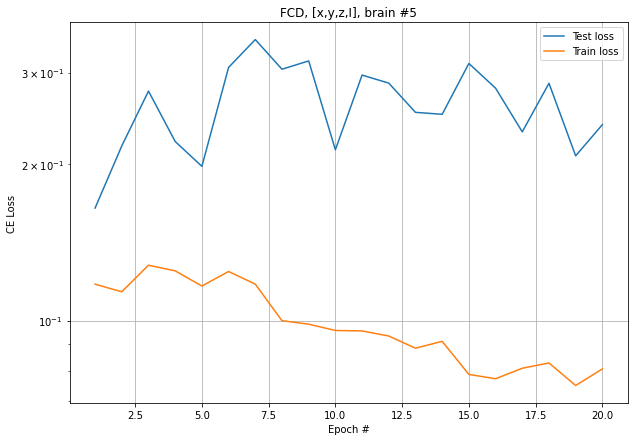

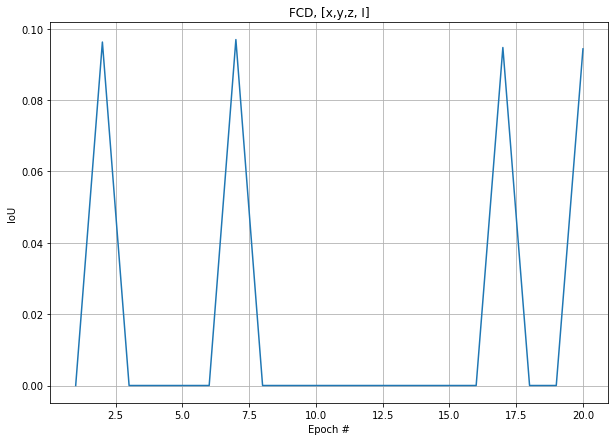

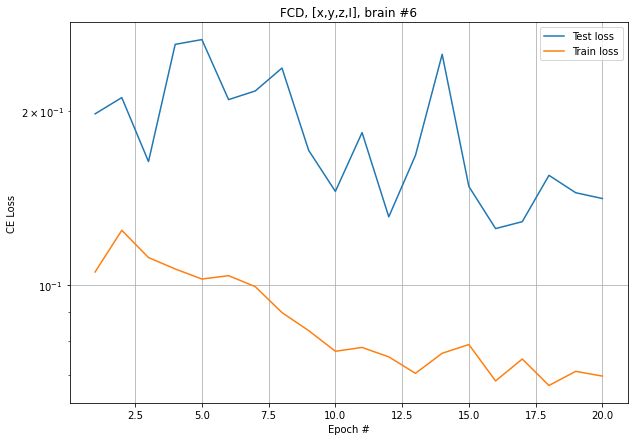

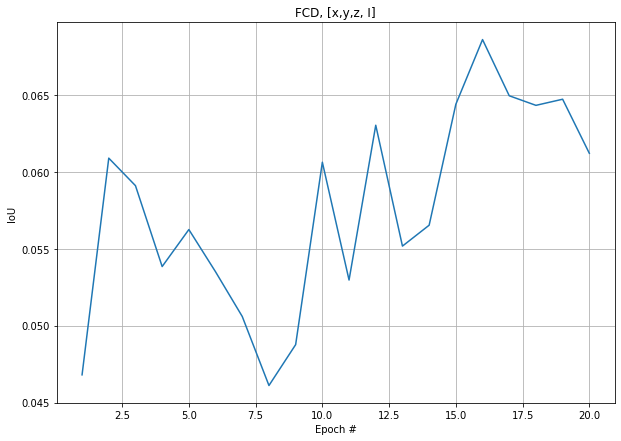

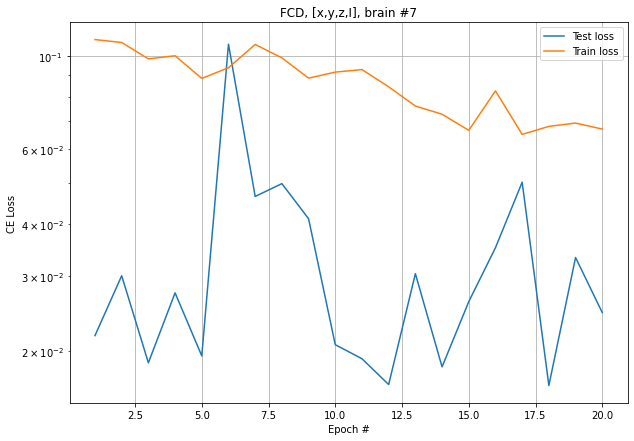

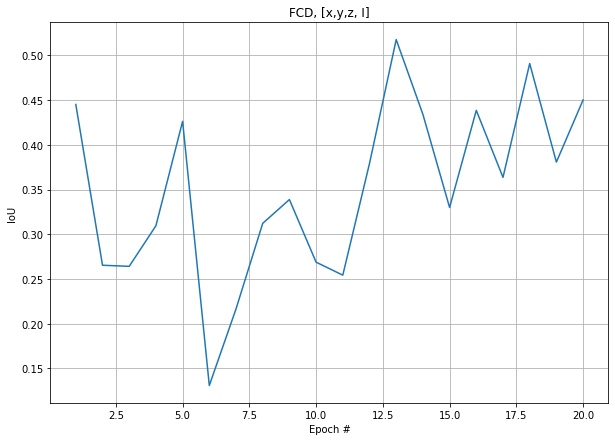

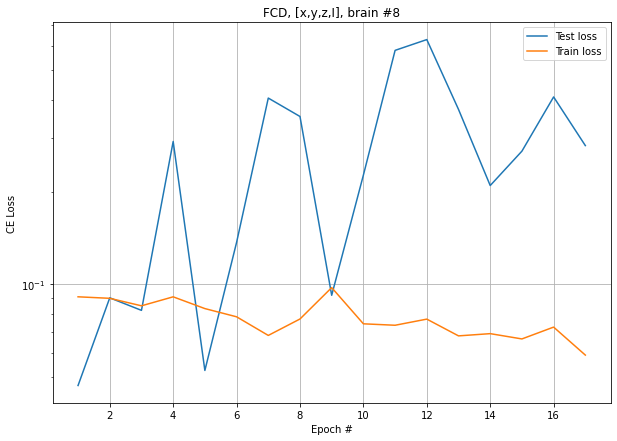

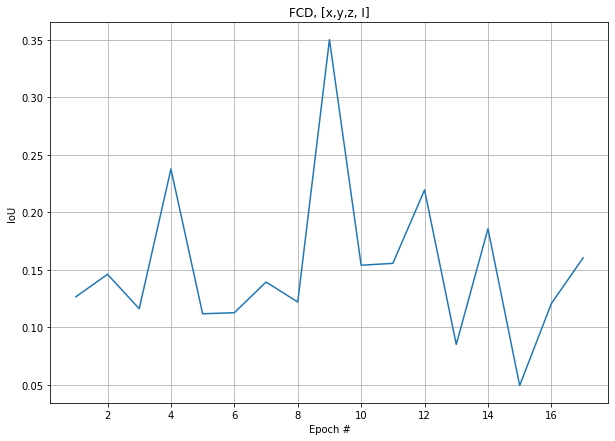

In [47]:
with open('4_exp_output.pkl', 'rb') as handle:
    res_dict = pickle.load(handle)
for i, e in enumerate(res_dict):    
    plt.figure(figsize = (10,7))
    plt.semilogy(range(1, len(res_dict[e]['iou'])+1),res_dict[e]['test_loss'], label = 'Test loss')
    plt.semilogy(range(1, len(res_dict[e]['iou'])+1),res_dict[e]['train_loss'], label = 'Train loss')
    plt.ylabel('CE Loss')
    plt.xlabel('Epoch #')
    plt.legend()
    plt.grid()
    plt.title('FCD, [x,y,z,I], brain #' + str(i+1))
    if i == 5:
        plt.savefig('fcd4.pdf')
    plt.show()

    plt.figure(figsize = (10,7))
    plt.plot(range(1, len(res_dict[e]['iou'])+1),res_dict[e]['iou'])
    plt.grid()
    plt.title('FCD, [x,y,z, I]')
    plt.ylabel('IoU')
    plt.xlabel('Epoch #')
    plt.show()

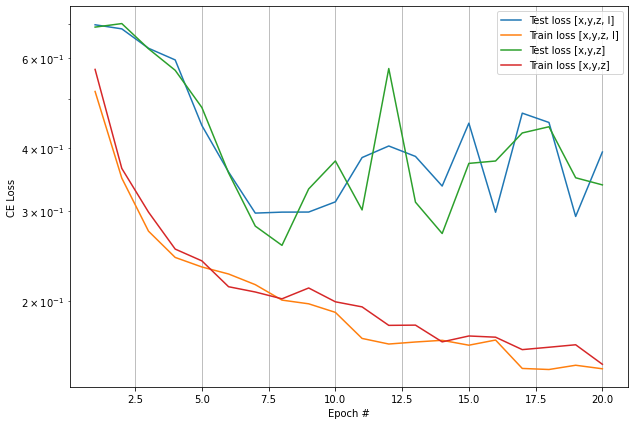

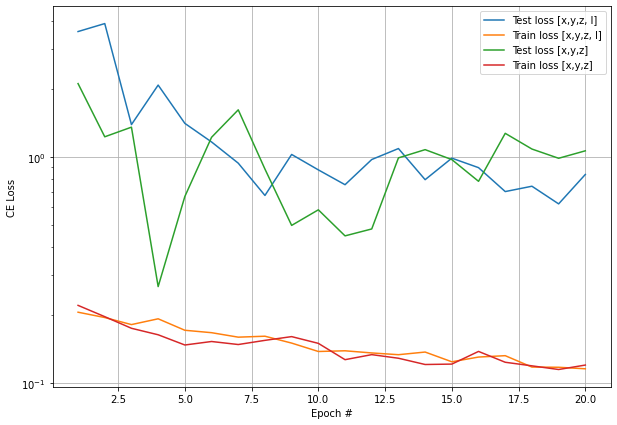

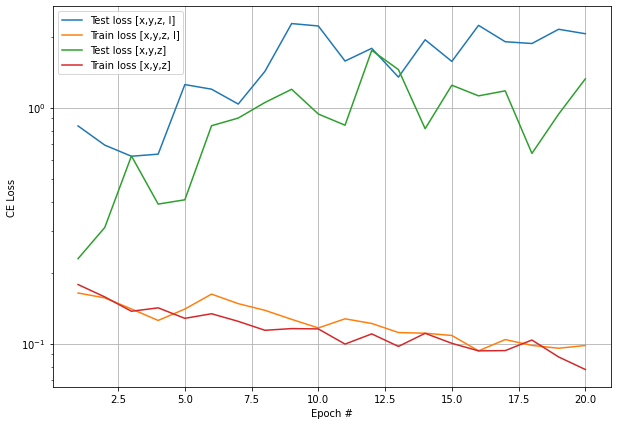

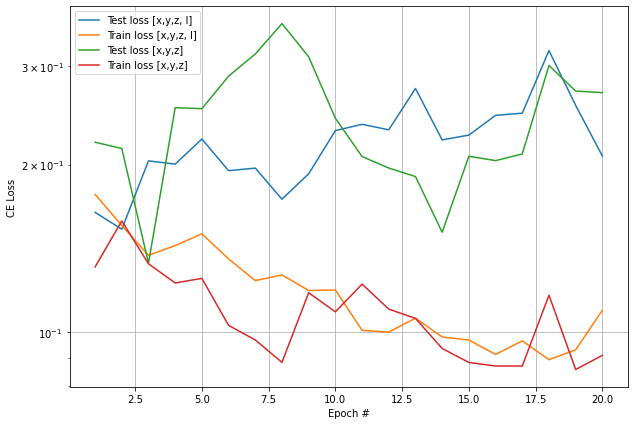

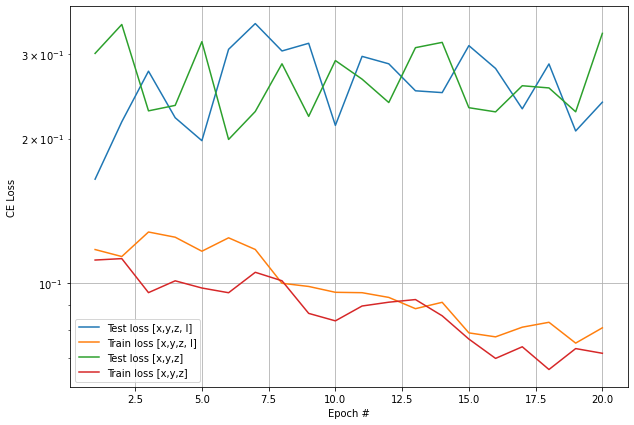

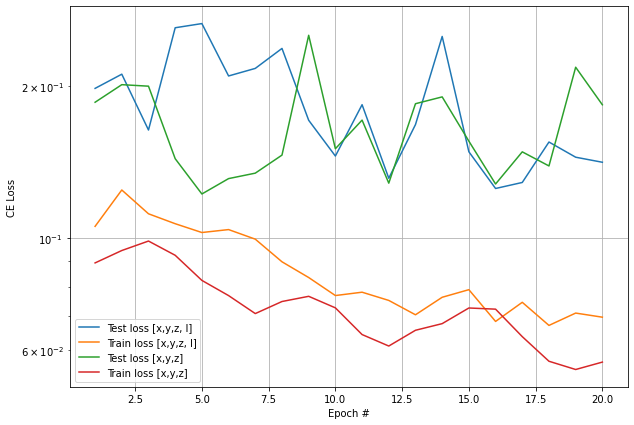

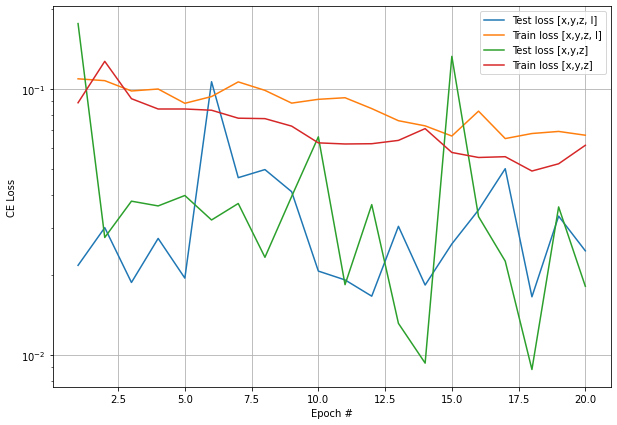

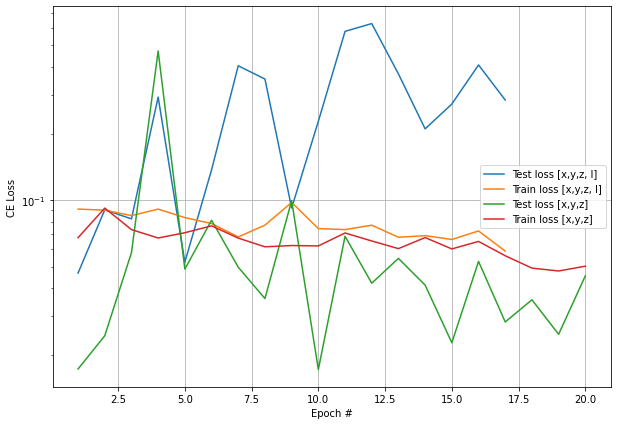

In [53]:
with open('4_exp_output.pkl', 'rb') as handle:
        res_dict = pickle.load(handle)
with open('3_exp_output.pkl', 'rb') as handle:
        res_dict_1 = pickle.load(handle)

for i, e in enumerate(res_dict):
    plt.figure(figsize = (10,7))
    plt.semilogy(range(1, len(res_dict[e]['test_loss'])+1)[:20],res_dict[e]['test_loss'][:20], label = 'Test loss [x,y,z, I]')
    plt.semilogy(range(1, len(res_dict[e]['test_loss'])+1)[:20],res_dict[e]['train_loss'][:20], label = 'Train loss [x,y,z, I]')
    plt.semilogy(range(1, len(res_dict_1[e]['test_loss'])+1)[:20],res_dict_1[e]['test_loss'][:20], label = 'Test loss [x,y,z]')
    plt.semilogy(range(1, len(res_dict_1[e]['test_loss'])+1)[:20],res_dict_1[e]['train_loss'][:20], label = 'Train loss [x,y,z]')
    plt.ylabel('CE Loss')
    plt.xlabel('Epoch #')
    plt.legend()
    plt.grid()
    #plt.title('Loss')
    #plt.title('FCD, [x,y,z] vs. [x,y,z, I], brain #'+str(i+1))
    if i == 5:
        plt.savefig('fcd3+fcd4_loss.pdf')
    plt.show()

In [54]:
! wget -qO- bench.sh | bash 

sysctl: cannot stat /proc/sys/net/ipv4/tcp_congestion_control: No such file or directory
----------------------------------------------------------------------
 CPU Model             : Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
 CPU Cores             : 56
 CPU Frequency         : 1608.000 MHz
 CPU Cache             : 35840 KB
 Total Disk            : 7605.7 GB (4314.8 GB Used)
 Total Mem             : 128678 MB (117341 MB Used)
 Total Swap            : 65535 MB (42589 MB Used)
 System uptime         : 21 days, 3 hour 1 min
 Load average          : 77.38, 76.89, 75.12
 OS                    : Ubuntu 18.04.4 LTS
 Arch                  : x86_64 (64 Bit)
 Kernel                : 4.4.0-128-generic
 TCP CC                : 
 Virtualization        : Docker
 Organization          : AS29226 JSC Mastertel
 Location              : Moscow / RU
 Region                : Moscow
----------------------------------------------------------------------
 I/O Speed(1st run)    : 431 MB/s
 I/O Speed(2nd run) 